In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

import pingouin as pg
from scipy import stats
from scipy.stats import spearmanr

import evaluate
metric = evaluate.load("rouge")

INCLUDE_PPL = False

Using the latest cached version of the module from /home/bertolo/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--rouge/b01e0accf3bd6dd24839b769a5fda24e14995071570870922c71970b3a6ed886 (last modified on Mon Sep 25 10:09:59 2023) since it couldn't be found locally at evaluate-metric--rouge, or remotely on the Hugging Face Hub.


# Loading Data

In [2]:
model_name_conv_tabel = {
    "google-t5-t5-small": ["T5-Small", 60.5],
    "google-t5-t5-base": ["T5-Base", 223],
    "google-t5-t5-large": ["T5-Large", 738],
    "Llama-3.2-1B": ["Llama-3.2-1B", 1240],
    "Llama-3.2-3B": ["Llama-3.2-3B", 3210],
}

model_order = ["T5-Small", "T5-Base", "T5-Large", "Llama-3.2-1B", "Llama-3.2-3B"]

In [3]:
full_df_lst = []
full_trn_df_lst = []

ftt_rg = []

for pnrt_mdl_id in tqdm(model_name_conv_tabel.keys()):

    # Load Data
    tr_df = pd.read_csv(f"preda_{pnrt_mdl_id}_loss_rouge.csv")
    prefix_based_dataset_df_test = pd.read_csv(f"preda_{pnrt_mdl_id}_results_full.csv")
    prefix_based_dataset_df_Train = pd.read_csv(f"preda_{pnrt_mdl_id}_train_set.csv")

    tr_df["mdl_id"] = [pnrt_mdl_id] * len(tr_df)
    tr_df["Model"] = [model_name_conv_tabel[pnrt_mdl_id][0]] * len(tr_df)
    tr_df["Size"] = [model_name_conv_tabel[pnrt_mdl_id][1]] * len(tr_df)

    full_trn_df_lst.append(tr_df)

    results_all = metric.compute(
        predictions=prefix_based_dataset_df_test["Model Predictions"],
        references=prefix_based_dataset_df_test["annotation"]
    )
    for mtrc, scr in results_all.items():
        ftt_rg.append([mtrc, 100*scr, "Overall", pnrt_mdl_id, model_name_conv_tabel[pnrt_mdl_id][0], model_name_conv_tabel[pnrt_mdl_id][1]])

    for prfx in set(prefix_based_dataset_df_Train["prefix"]):
        results_pfx = metric.compute(
            predictions=list(prefix_based_dataset_df_test[prefix_based_dataset_df_test["prefix"] == prfx]["Model Predictions"]),
            references=list(prefix_based_dataset_df_test[prefix_based_dataset_df_test["prefix"] == prfx]["annotation"])
        )
        for mtrc, scr in results_pfx.items():
            ftt_rg.append([mtrc, 100*scr, prfx, pnrt_mdl_id, model_name_conv_tabel[pnrt_mdl_id][0], model_name_conv_tabel[pnrt_mdl_id][1]])


    # Add perplexity
    if INCLUDE_PPL:

        perplexity = evaluate.load("perplexity", module_type="metric")

        ppl_model_id = 'mistralai/Mistral-7B-v0.3'

        ppl_predictions = perplexity.compute(
            predictions=list(prefix_based_dataset_df_test["dream_report"]),
            model_id=ppl_model_id,
            batch_size=8,
        )

        prefix_based_dataset_df_test["PPL"] = ppl_predictions["perplexities"]


    # Add Dream and Annotation IDs and Frequencies
    Trn_drm_id = {
        dr:i+1 for i, dr in 
        enumerate(set(prefix_based_dataset_df_Train["dream_report"]))
    }

    Trn_drm_id["Missing"] = 0

    Trn_drm_frq = {
        dr:len(prefix_based_dataset_df_Train[
            prefix_based_dataset_df_Train["dream_report"].isin([dr])
        ])/len(prefix_based_dataset_df_Train)
        for dr in prefix_based_dataset_df_Train["dream_report"]
    }

    Trn_ann_frq = {
        ann:len(prefix_based_dataset_df_Train[
            prefix_based_dataset_df_Train["annotation"].isin([ann])
        ])/len(prefix_based_dataset_df_Train)
        for ann in prefix_based_dataset_df_Train["annotation"]
    }

    prefix_based_dataset_df_test["Train_Dream_id"] = [
        Trn_drm_id.get(dr, 0) for dr in prefix_based_dataset_df_test["dream_report"]
    ]


    prefix_based_dataset_df_test["Dream_Trn_fq"] = [
        Trn_drm_frq.get(dr, 0) for dr in prefix_based_dataset_df_test["dream_report"]
    ]

    prefix_based_dataset_df_test["Annot_Trn_fq"] = [
        Trn_ann_frq.get(dr, 0) for dr in prefix_based_dataset_df_test["annotation"]
    ]


    # Add/Rename Number of Source/Trget Tokens
    prefix_based_dataset_df_test["N_Source_Tkns"] = prefix_based_dataset_df_test["Token_N°_text"]
    prefix_based_dataset_df_test["N_Target_Tkns"] = prefix_based_dataset_df_test["Token_N°"]

    # Add Model's is, name, size
    prefix_based_dataset_df_test["mdl_id"] = [pnrt_mdl_id] * len(prefix_based_dataset_df_test)
    prefix_based_dataset_df_test["Model"] = [model_name_conv_tabel[pnrt_mdl_id][0]] * len(prefix_based_dataset_df_test)
    prefix_based_dataset_df_test["Size"] = [model_name_conv_tabel[pnrt_mdl_id][1]] * len(prefix_based_dataset_df_test)

    full_df_lst.append(prefix_based_dataset_df_test)

ftt_rg_df = pd.DataFrame(ftt_rg, columns=["Metric", "Score", "Feature", "Model_id", "Model", "Size"])

100% 5/5 [00:27<00:00,  5.57s/it]


In [4]:
prefix_to_use = list(set(prefix_based_dataset_df_test["prefix"]))

In [5]:
full_trn_df = pd.concat(full_trn_df_lst).reset_index(drop=True)
full_df = pd.concat(full_df_lst).reset_index(drop=True)

# Main Experiment Results 

In [6]:
overall_ftt_rg_df = ftt_rg_df[ftt_rg_df["Feature"] == "Overall"]

overall_ftt_rg_df_p = overall_ftt_rg_df.pivot(index="Size", columns="Metric", values="Score")

In [7]:
sns.set_context("talk")
sns.set_style("whitegrid")

In [8]:
av_sml_bs = overall_ftt_rg_df_p.values[0] - overall_ftt_rg_df_p.values[1]
print(f"{np.mean(av_sml_bs).round(2)} ± {stats.sem(av_sml_bs).round(2)}")

av_bs_lrg = overall_ftt_rg_df_p.values[1] - overall_ftt_rg_df_p.values[2]
print(f"{np.mean(av_bs_lrg).round(2)} ± {stats.sem(av_bs_lrg).round(2)}")

av_sml_lrg = overall_ftt_rg_df_p.values[0] - overall_ftt_rg_df_p.values[2]
print(f"{np.mean(av_sml_lrg).round(2)} ± {stats.sem(av_sml_lrg).round(2)}")

5.49 ± 0.08
13.62 ± 1.38
19.12 ± 1.31


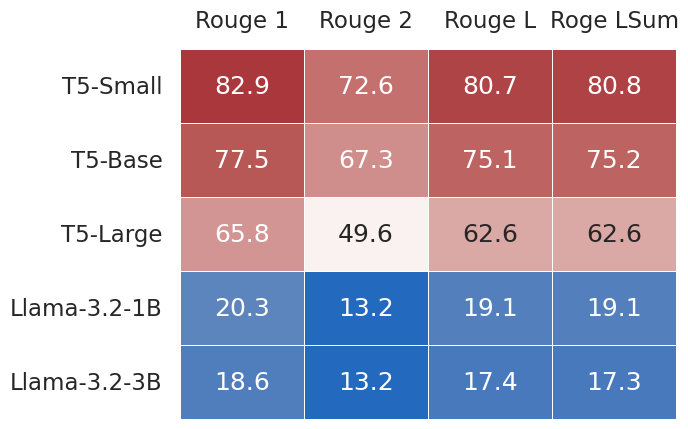

In [9]:
htmp_cpll = "vlag"
sns.set("talk", "white")

g = sns.heatmap(
    overall_ftt_rg_df_p,
    annot=True,
    fmt=".1f",
    linewidth=.5,
    cmap=htmp_cpll,
    cbar=False,
    square=False,
    # vmin=0,
    # vmax=100,
)

g.set(xticklabels=["Rouge 1", "Rouge 2", "Rouge L", "Roge LSum"], yticklabels=model_order)
plt.tick_params(axis='both', which='major', labelbottom=False, bottom=False, top=False, labeltop=True)
g.set(xlabel="", ylabel="")

g.figure.savefig('Images/htmp_models_metrics.png', dpi=300, bbox_inches='tight')

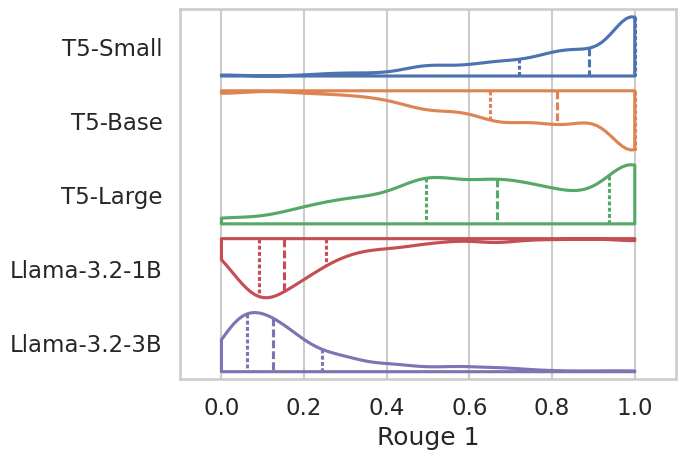

In [10]:
sns.set("talk", "whitegrid")

g = sns.violinplot(
    data=full_df,
    x="Rouge 1",
    y="Model",
    hue="Model",
    inner="quart",
    split=True,
    fill=False,
    # order=["Activities", "Characters", "Emotion", "Friendliness", "Good Fortune", "Misfortune"],
    cut=0,
)

g.set(xlim=(-.1, 1.1), ylabel="")

g.figure.savefig('Images/vlnplt_mdls_rg1.png', dpi=300, bbox_inches='tight')

In [11]:
train_set = pd.read_csv("preda_google-t5-t5-small_train_set.csv")

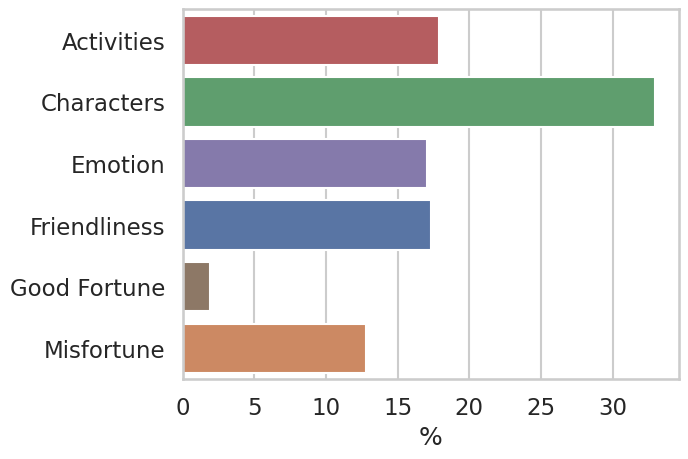

In [12]:
g = sns.countplot(
    data=train_set,
    y="prefix",
    hue="prefix",
    order=["Activities", "Characters", "Emotion", "Friendliness", "Good Fortune", "Misfortune"],
    stat="percent",
)

g.set(ylabel="", xlabel="%")
g.figure.savefig('Images/trn_st_prfx_prcnt.png', dpi=300, bbox_inches='tight')

## Statistical Analysis

In [13]:
from mlxtend.evaluate import permutation_test

In [14]:
def get_sig_astrisc(r, p, round_lev=2):
    if .001 > p:
        return f"{str(r.round(2))[:5]}***"
    elif .01 > p:
        return f"{str(r.round(2))[:5]}**"
    elif .05 > p:
        return f"{str(r.round(2))[:5]}*"
    elif .05 < p:
        return f"{str(r.round(2))[:5]}"
    else:
        print(r.round(round_lev), p)

H_0: the two sample come from the same distribution

In [15]:
# Compare Means
pval_df = []

for a,b in tqdm([("Small", "Base"), ("Small", "Large"), ("Base", "Large")]):
    x = list(full_df[full_df["Model"] == f"T5-{a}"]["Rouge 1"])
    y = list(full_df[full_df["Model"] == f"T5-{b}"]["Rouge 1"])

    p_value = permutation_test(
        x,
        y,
        method='approximate',
        num_rounds=10000,
        seed=0,
        paired=True,
    )
    pval_df.append([f"T5-{a} - t5-{b}", p_value])

pval_df = pd.DataFrame(pval_df, columns=["Compared", "p"])

reject, pvals_corr = pg.multicomp(pval_df["p"], method="holm")
pval_df["reject H0"], pval_df["p Holm"] = reject, pvals_corr

100% 3/3 [00:11<00:00,  3.67s/it]


In [16]:
pval_df

,Compared,p,reject H0,p Holm
0,T5-Small - t5-Base,0.0001,True,0.0003
1,T5-Small - t5-Large,0.0001,True,0.0003
2,T5-Base - t5-Large,0.0001,True,0.0003


# Single Model Analysis 
## Training regime

In [17]:
best_model = "T5-Small"

prefix_based_dataset_df_test = full_df[full_df["Model"] == best_model].reset_index(drop=True)
tr_df = full_trn_df[full_trn_df["Model"] == best_model].reset_index(drop=True)

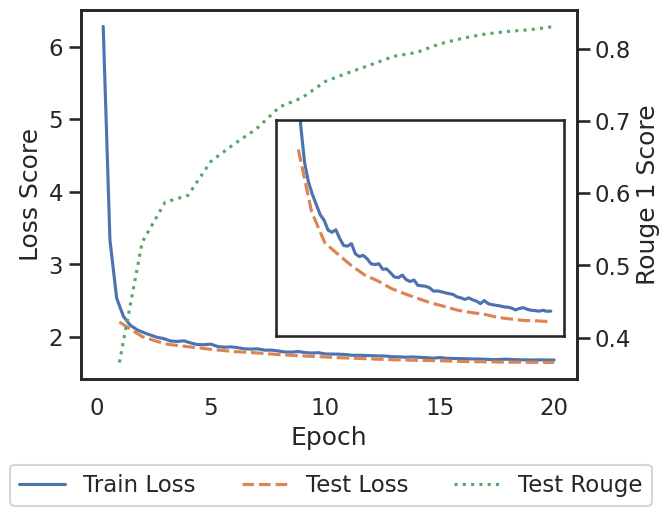

In [18]:
sns.set_style("white")

bl, orng, grn = sns.color_palette()[:3]

custom_lines = [
    Line2D([0], [0], color=bl),
    Line2D([0], [0], color=orng, linestyle="--"),
    Line2D([0], [0], color=grn, linestyle=":")
]

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax3 = plt.axes([0.43, 0.2, .45, .45])

# Losses
g = sns.lineplot(
    data=tr_df[tr_df["Variable"].isin(["loss", "eval_loss"])],
    x="Epoch",
    y="Value",
    hue="Variable",
    style="Variable",
    ax=ax1,
    legend=None
)

# zoom
g = sns.lineplot(
    data=tr_df[tr_df["Variable"].isin(["loss", "eval_loss"])],
    x="Epoch",
    y="Value",
    hue="Variable",
    style="Variable",
    legend=None,
    ax=ax3
)

g.set(xticklabels=[], xlabel="", yticklabels=[], ylabel="")
g.tick_params(bottom=False)  # remove the ticks

g.set(ylim=(1.6, 2.3))


# Rouge
g = sns.lineplot(
    data=tr_df[tr_df["Variable"].isin(["eval_rouge1"])],
    x="Epoch",
    y="Value",
    linestyle="dotted",
    color=grn,
    ax=ax2
)

ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss Score')
ax2.set_ylabel('Rouge 1 Score')

ax2.legend(
    custom_lines,
    ['Train Loss', 'Test Loss', 'Test Rouge'],
    bbox_to_anchor=(1.175, -.2),
    ncol=3
)

plt.show()
fig.savefig('Images/lnplot_lossesrg1_mrgd.png', dpi=300, bbox_inches='tight')

## Rouge
### Overall

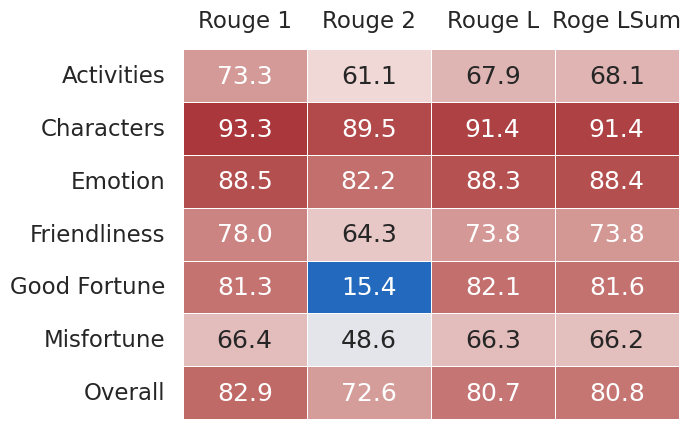

In [19]:
ftt_rg_df_p = ftt_rg_df[ftt_rg_df["Model"] == "T5-Small"].reset_index(drop=True).pivot(index="Feature", columns="Metric", values="Score")

htmp_cpll = "vlag"

g = sns.heatmap(
    ftt_rg_df_p,
    annot=True,
    fmt=".1f",
    linewidth=.5,
    cmap=htmp_cpll,
    cbar=False,
    # vmin=0,
    # vmax=100,
)

g.set(xticklabels=["Rouge 1", "Rouge 2", "Rouge L", "Roge LSum"])
plt.tick_params(axis='both', which='major', labelbottom = False, bottom=False, top = False, labeltop=True)
g.set(xlabel="", ylabel="")

g.figure.savefig('Images/htmp_prefix_metrics.png', dpi=300, bbox_inches='tight')

### Distribution

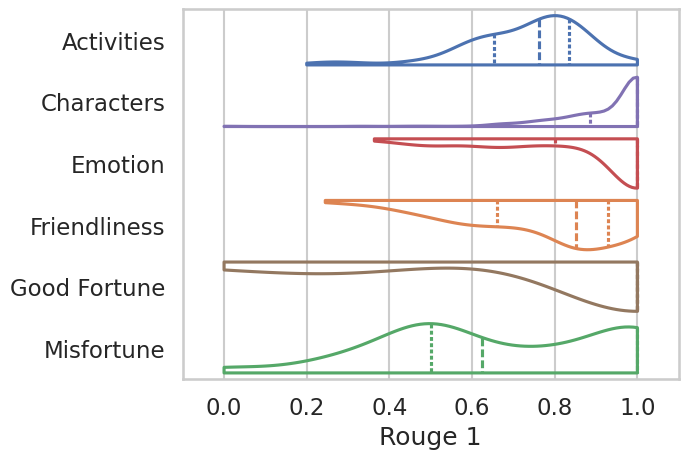

In [20]:
sns.set("talk", "whitegrid")

g = sns.violinplot(
    data=prefix_based_dataset_df_test,
    x="Rouge 1",
    y="prefix",
    hue="prefix",
    inner="quart",
    split=True,
    fill=False,
    order=["Activities", "Characters", "Emotion", "Friendliness", "Good Fortune", "Misfortune"],
    cut=0,
)

g.set(xlim=(-.1, 1.1), ylabel="")

g.figure.savefig('Images/vlnplt_prfx_rg1.png', dpi=300, bbox_inches='tight')

In [21]:
pdist = ['Activities', 'Friendliness', 'Characters', 'Emotion', 'Good Fortune', 'Misfortune']

### Correlation
#### Rouge to Dream Report

In [22]:
rho_pval_df = []
x = "Rouge 1"

In [23]:
y = "Dream_Trn_fq"

print(f"X: {x}; y:{y}")

r, p = spearmanr(
    prefix_based_dataset_df_test[x],
    prefix_based_dataset_df_test[y]
)
rho_pval_df.append([r, p, f"{y} - Overall"])
# print(r, p)

X: Rouge 1; y:Dream_Trn_fq


In [24]:
print(f"X: {x}; y:{y}")

for pref in prefix_to_use:
    test_df = prefix_based_dataset_df_test[prefix_based_dataset_df_test["prefix"].isin([pref])]
    a = list(test_df[x])
    b = list(test_df[y])
    r, p = spearmanr(a, b)
    rho_pval_df.append([r, p, f"{y} - {pref}"])
    # print(pref, r, p)

X: Rouge 1; y:Dream_Trn_fq


#### Rouge to Source tokens

In [25]:
y = "N_Source_Tkns"

print(f"X: {x}; y:{y}")

r, p = spearmanr(
    prefix_based_dataset_df_test[x],
    prefix_based_dataset_df_test[y]
)
rho_pval_df.append([r, p, f"{y} - Overall"])
# print(r, p)

X: Rouge 1; y:N_Source_Tkns


In [26]:
print(f"X: {x}; y:{y}")

for pref in prefix_to_use:
    test_df = prefix_based_dataset_df_test[prefix_based_dataset_df_test["prefix"].isin([pref])]
    a = list(test_df[x])
    b = list(test_df[y])
    r, p = spearmanr(a, b)
    rho_pval_df.append([r, p, f"{y} - {pref}"])
    # print(pref, r, p)

X: Rouge 1; y:N_Source_Tkns


#### Rouge to Target tokens

In [27]:
y = "N_Target_Tkns"

print(f"X: {x}; y: {y}")

r, p = spearmanr(
    prefix_based_dataset_df_test[x],
    prefix_based_dataset_df_test[y]
)
rho_pval_df.append([r, p, f"{y} - Overall"])
# print(r, p)

X: Rouge 1; y: N_Target_Tkns


In [28]:
print(f"X: {x}; y:{y}")

for pref in prefix_to_use:
    test_df = prefix_based_dataset_df_test[prefix_based_dataset_df_test["prefix"].isin([pref])]
    a = list(test_df[x])
    b = list(test_df[y])
    r, p = spearmanr(a, b)
    rho_pval_df.append([r, p, f"{y} - {pref}"])
    # print(pref, r, p)

X: Rouge 1; y:N_Target_Tkns


In [29]:
rho_pval_df = pd.DataFrame(rho_pval_df, columns=["Rho", "p", "id"])

In [30]:
p_corr_mthd = 'holm'
pvals = list(rho_pval_df["p"])
reject, pvals_corr = pg.multicomp(pvals, method=p_corr_mthd)
rho_pval_df[f"{p_corr_mthd}_p"] = pvals_corr
rho_pval_df["reject H0"] = reject

#### Correction and visualisation

In [31]:
rho_pval_df["sig_rho"] = [
    get_sig_astrisc(rho, pv) for rho, pv
    in rho_pval_df[["Rho", "holm_p"]].values
]

In [32]:
htmp_cnv_tbl = {
    "Dream_Trn_fq " : "Dream Fq.",
    "Annot_Trn_fq " : "Annotation Fq.",
    "N_Source_Tkns ": "N° Source Tokens",
    "N_Target_Tkns ": "N° Target Tokens",
}

In [33]:
sns.set_context("notebook")
sns.set_style("whitegrid")

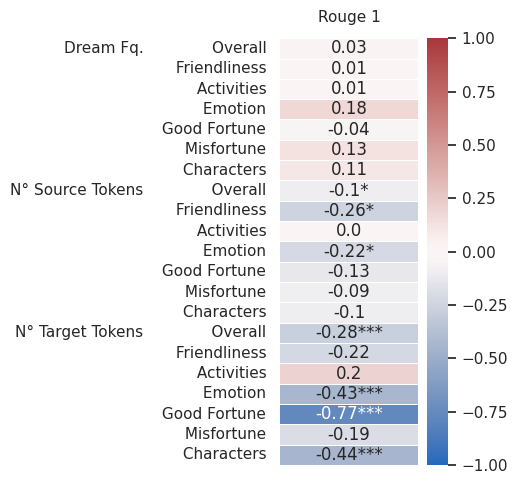

In [34]:
plt.figure(figsize = (5,5))

g = sns.heatmap(
    rho_pval_df["Rho"].values.reshape(21, 1),
    annot=rho_pval_df["sig_rho"].values.reshape(21, 1),
    fmt="",
    cmap=htmp_cpll,
    linewidth=.7,
    cbar=True,
    # square=True,
    vmin=-1,
    vmax=1,
)

y_ticks = [
    "             ".join([htmp_cnv_tbl[t.split("-")[0]], t.split("-")[1]])
    if i in [0, 7, 14] else t.split("-")[1]
    for i, t in enumerate(rho_pval_df["id"].values.reshape(21))
]
g.set_yticklabels(y_ticks)

g.set_xticklabels([x])
plt.tick_params(axis='both', which='major', labelbottom=False, bottom=False, top = False, labeltop=True)
print()
plt.tight_layout()

g.figure.savefig('Images/htmp_rg1_corr.png', dpi=300, bbox_inches='tight')